In [1]:
import sys
import os
import struct
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
root = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(os.path.join(root, 'code'))
from plotting_and_analysis import plot_utils, summary_plots, spatial_fits, analysis_utils
plot_utils.set_plotting_defaults()

In [2]:
subject = 1
volume_space=True
fitting_type1 = 'sketch_tokens_pca'
# fitting_type = 'bdcn_pca_fused'
# fitting_type1 = 'texture_pyramid_ridge_4ori_4sf'
# fitting_type1 = 'gabor_solo_ridge_4ori_4sf'
# fitting_type1 = 'texture_gabor_ridge_4ori_4sf'
# fitting_type2 = 'sketch_tokens_pca'
# fitting_type2 = 'texture_pyramid_pcaHL_ridge_4ori_4sf'
# fitting_type2 = 'sketch_tokens_lda'
fitting_type2 = 'sketch_tokens_lda_animacy'

root = os.path.dirname(os.path.dirname(os.getcwd()))
out1, fig_save_folder = analysis_utils.load_fit_results(subject, volume_space, fitting_type1, n_from_end=0, root=root, verbose=True);
analysis_utils.print_output_summary(out1)

out2, fig_save_folder = analysis_utils.load_fit_results(subject, volume_space, fitting_type2, n_from_end=0, root=root, verbose=True);
analysis_utils.print_output_summary(out2)

if not os.path.exists(fig_save_folder):
    os.makedirs(fig_save_folder)
    


loading from /user_data/mmhender/imStat/model_fits/S01/sketch_tokens_pca/Oct-11-2021_1244_28/all_fit_params

dict_keys(['subject', 'volume_space', 'fitting_type', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'aperture', 'aperture_rf_range', 'models', 'n_prf_sd_out', 'best_losses', 'best_lambdas', 'best_params', 'lambdas', 'val_cc', 'val_r2', 'partial_masks', 'partial_version_names', 'stack_result', 'stack_result_lo', 'partial_models_used_for_stack', 'train_r2', 'train_cc', 'zscore_features', 'ridge', 'debug', 'up_to_sess', 'shuff_rnd_seed', 'min_pct_var', 'max_pc_to_retain', 'use_pca_st_feats', 'use_lda_st_feats', 'use_lda_animacy_st_feats'])
subject = 1
volume_space = 1
fitting_type = sketch_tokens
voxel_mask: shape (699192,)
brain_nii_shape: shape (3,)
image_order: shape (30000,)
voxel_index: len 1
voxel_roi: len 2
voxel_ncsnr: shape (699192,)
aperture = 1.0
aperture_rf_range = 1.1
models: shape (875, 3)
n_prf_sd_out = 2
best_losses: shap

In [24]:
fig_save_folder = '/user_data/mmhender/imStat/figures/S01/compare_models/'
# os.makedirs(fig_save_folder)

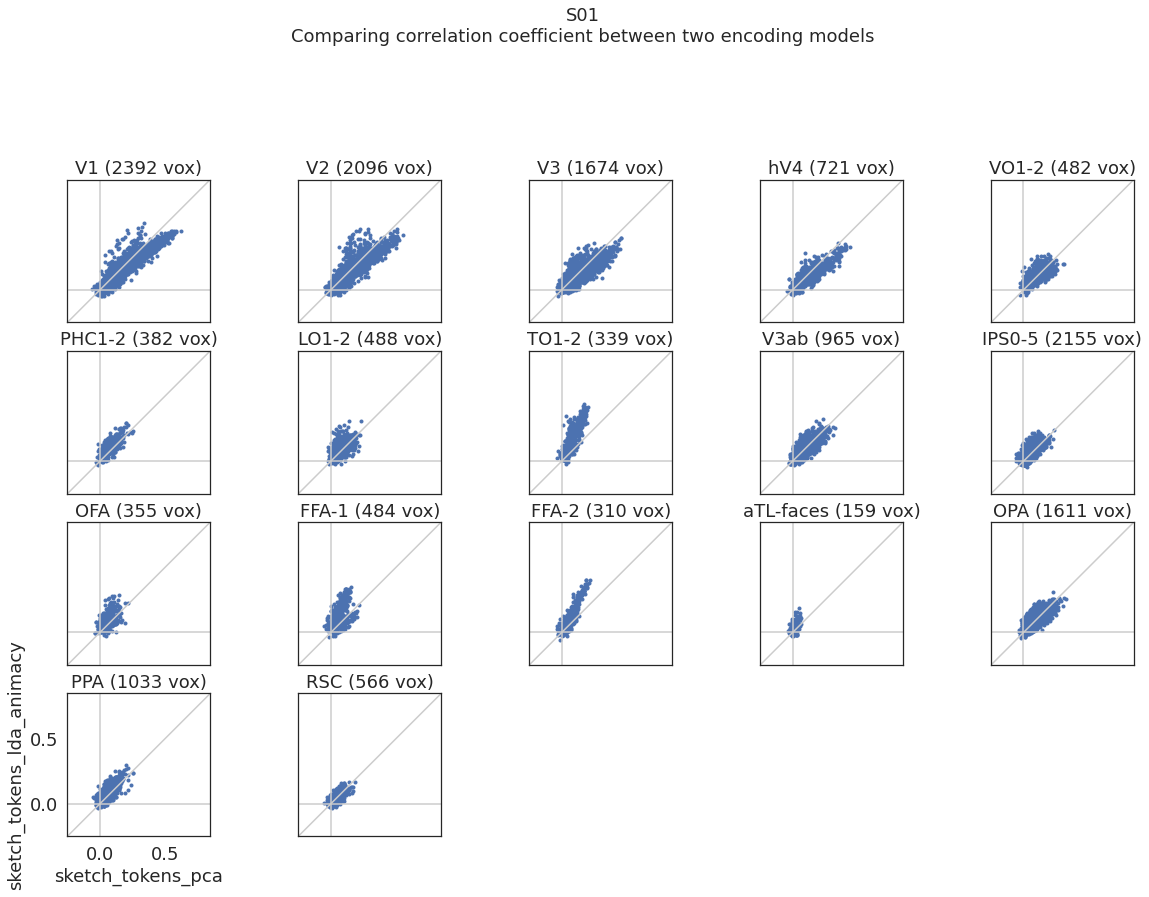

In [3]:
plot_utils.set_all_font_sizes(fs = 18)
cc_cutoff = 0.20
val_cc1 = out1['val_cc'][:,0:1]
val_cc2 = out2['val_cc'][:,0:1]
dat = np.concatenate((val_cc1,val_cc2), axis=1)

inds2use = np.ones([len(val_cc1),])==1

sp = plot_utils.scatter_plot(color=None, xlabel=fitting_type1, ylabel=fitting_type2, \
                             xlims=[-0.25, 0.85], ylims=[-0.25, 0.85], \
                  xticks=[0, 0.5], yticks=[0, 0.5],\
                  show_diagonal=True, show_axes=True);

plot_utils.create_roi_subplots(dat, inds2use, sp, subject, out1,\
                    suptitle='S%02d\nComparing correlation coefficient between two encoding models'%(subject), \
                   label_just_corner=True, figsize=(20,24))

plt.gcf().subplots_adjust(bottom=0.5)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'scatter_%s_vs_%s_eachroi.pdf'%(fitting_type1, fitting_type2)))
    plt.savefig(os.path.join(fig_save_folder,'scatter_%s_vs_%s_eachroi.png'%(fitting_type1, fitting_type2)))

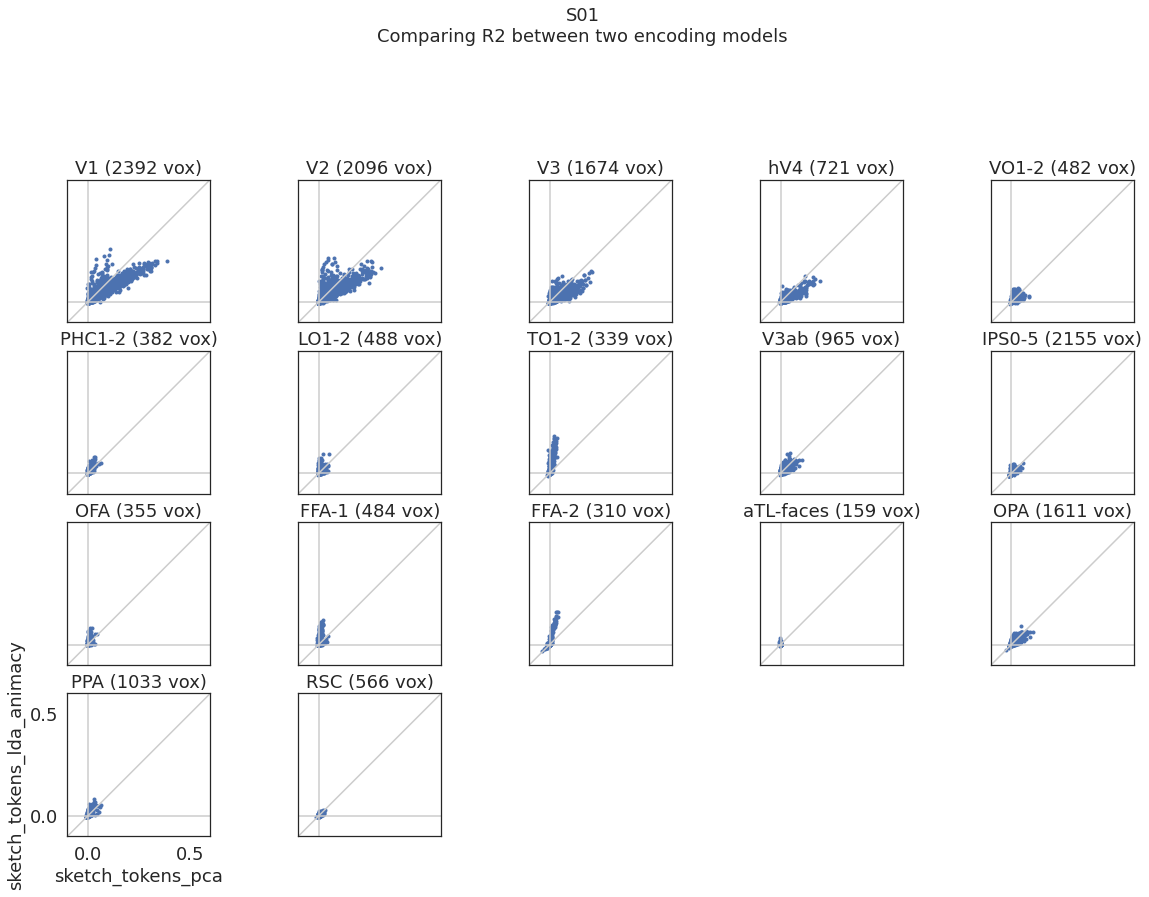

In [15]:
plot_utils.set_all_font_sizes(fs = 18)
cc_cutoff = 0.20
val_rsq1 = out1['val_r2'][:,0:1]
val_rsq2 = out2['val_r2'][:,0:1]
dat = np.concatenate((val_rsq1,val_rsq2), axis=1)

inds2use = np.ones([len(val_cc1),])==1

sp = plot_utils.scatter_plot(color=None, xlabel=fitting_type1, ylabel=fitting_type2, \
                             xlims=[-0.10, 0.60], ylims=[-0.10, 0.60], \
                  xticks=[0, 0.5], yticks=[0, 0.5],\
                  show_diagonal=True, show_axes=True);

plot_utils.create_roi_subplots(dat, inds2use, sp, subject, out1,\
                    suptitle='S%02d\nComparing R2 between two encoding models'%(subject), \
                   label_just_corner=True, figsize=(20,24))

plt.gcf().subplots_adjust(bottom=0.5)
if fig_save_folder is not None:
    plt.savefig(os.path.join(fig_save_folder,'scatter_%s_vs_%s_eachroi.pdf'%(fitting_type1, fitting_type2)))
    plt.savefig(os.path.join(fig_save_folder,'scatter_%s_vs_%s_eachroi.png'%(fitting_type1, fitting_type2)))

In [4]:
from plotting_and_analysis import analysis_utils, spatial_fits
import copy

retlabs, catlabs, ret_group_names, categ_group_names = analysis_utils.get_combined_rois(subject, out1)
best_ecc_deg, best_angle_deg, best_size_deg = spatial_fits.get_prf_pars_deg(out1, screen_eccen_deg=8.4)

port=33333

names0 = ['pRF eccentricity', 'pRF angle', 'pRF size']
maps0 = [best_ecc_deg, best_angle_deg, best_size_deg]
cmaps0 = ['PRGn', 'Retinotopy_RYBCR', 'PRGn']
mins0 = [0,0,0]
maxes0 = [7, 360, 4]

names1 = ['R2: %s'%fitting_type1,'R2: %s'%fitting_type2, 'model w higher R2']

val_rsq1 = copy.deepcopy(out1['val_r2'][:,0:1])
val_rsq2 = copy.deepcopy(out2['val_r2'][:,0:1])
dat = np.concatenate((val_rsq1,val_rsq2), axis=1)

max_ind = (np.argmax(dat, axis=1)+1).astype(np.float32)

bad_voxels = np.squeeze((val_rsq1<0) &  (val_rsq2<0))
val_rsq1[bad_voxels] = np.nan
val_rsq2[bad_voxels] = np.nan
max_ind[bad_voxels] = np.nan
maps1 = [np.squeeze(np.sqrt(val_rsq1)), np.squeeze(np.sqrt(val_rsq2)), max_ind]

cmaps1 = ['PuBu', 'PuBu', 'plasma_r']
mins1 = [0, 0, 0, 0, 0] 
maxes1 = [0.6, 0.6, 2]

maps = maps0+maps1
cmaps=cmaps0+cmaps1
names=names0+names1
mins=mins0+mins1
maxes=maxes0+maxes1

plot_utils.plot_maps_pycortex(maps, names, subject, out1, fitting_type1, port, cmaps=cmaps, mins=mins, maxes=maxes)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt


[nan nan nan ... nan nan nan]
[nan nan nan ... nan nan nan]
Data is in 3d volume space
navigate browser to: 127.0.0.1:33333
Started server on port 33333


In [10]:
np.sum(out1['voxel_roi'][0]==1)

1180

In [11]:
np.sum(out1['voxel_mask'])

14913

In [10]:
val_rsq1 = out1['val_r2'][:,0:1]
val_rsq2 = out2['val_r2'][:,0:1]
dat = np.concatenate((val_rsq1,val_rsq2), axis=1)

max_ind = (np.argmax(dat, axis=1)+1).astype(np.float32)


In [10]:
models1 = out1['best_params'][0][:,0,:]
models2 = out2['best_params'][0][:,0,:]

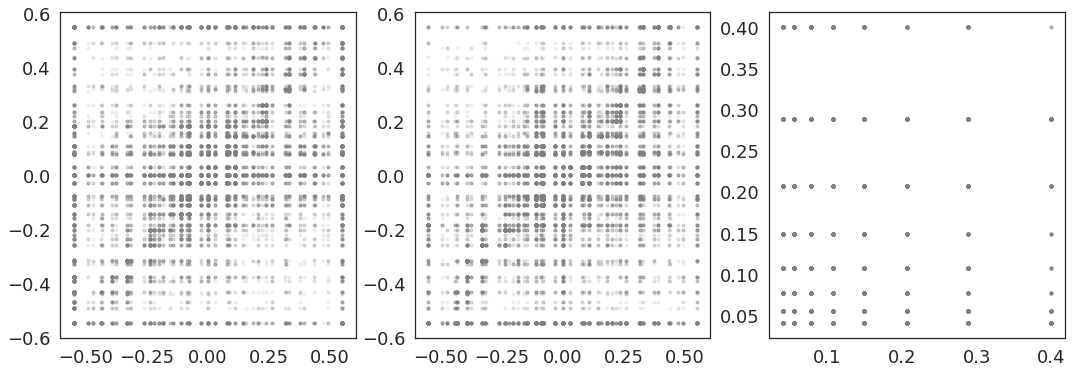

In [14]:
plt.figure(figsize=(18,6));
for ii in range(3):
    plt.subplot(1,3,ii+1)
    plt.plot(models1[:,ii], models2[:,ii],'.',color=[0.5, 0.5, 0.5, 0.1])